In [1]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Instance Segmentation

In [15]:
# Import Libraries

from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [90]:
# List all TIFF files in the folder

masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/masks'

tiff_files = [f for f in os.listdir(masks_folder) if f.endswith('.tif') or f.endswith('.tiff')]

# Initialize a list to store images
images = []

# Loop through and load each TIFF file
for file_name in tiff_files:
    file_path = os.path.join(masks_folder, file_name)

    # Load the image and convert to a NumPy array
    image = np.array(Image.open(file_path))

    # Ensure the image is 256x256, or resize if necessary
    if image.shape != (256, 256):
        image = np.array(Image.open(file_path).resize((256, 256)))

    # Append the quarters image to the list
    images.append(image)

# Convert the list of images into a 3D NumPy array
image_stack_masks = np.stack(images)

original_masks = image_stack_masks.reshape(-1, 256, 256)


print(f'image_stack_masks shape: ',original_masks.shape)  # Should be (n_images, 256, 256)


image_stack_masks shape:  (28, 256, 256)


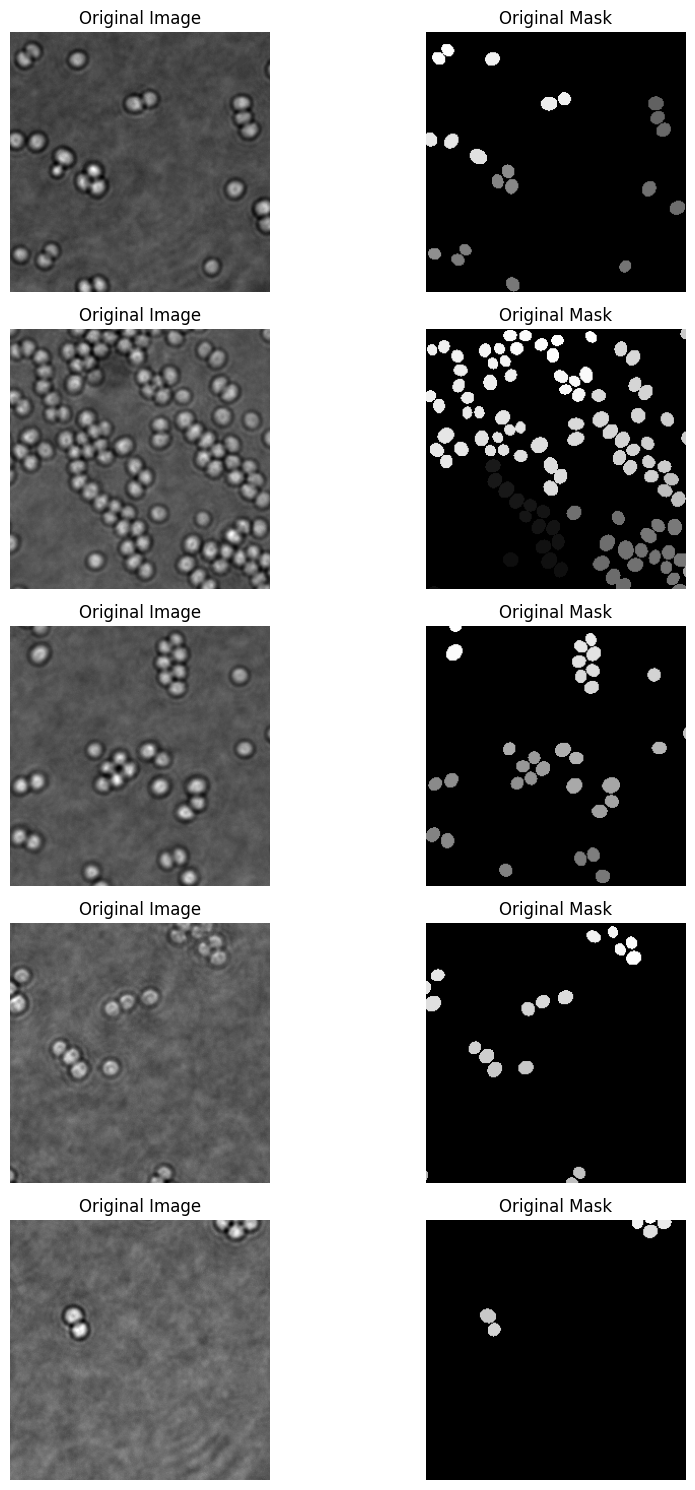

In [91]:
# Show Some Examples

num_examples = 5
plt.figure(figsize=(10, num_examples * 3))

for i in range(num_examples):
    plt.subplot(num_examples, 2, i * 2 + 1)
    plt.imshow(original_brightfield[i], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_examples, 2, i * 2 + 2)
    plt.imshow(original_masks[i], cmap="gray")
    plt.title("Original Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [92]:
# Cells in Each Mask 
'''
Function for getting Cell Count in an Image 
'''

def get_cell_count(image): 
    
    # Masked Image (256 x 256) 
    unique_colors = np.unique(image)
    cell_colors = unique_colors[unique_colors != 0]  # Exclude background (color 0)
    
    # Cell Count
    cell_count = len(cell_colors)    
    
    return cell_count, cell_colors


In [93]:
'''
Function for creating Instance Masks
'''

def get_instance_masks(image, plot = None): # Plot Masks - plot = 1
    Masks = []
    
    cell_count, cell_colors = get_cell_count(image)
    
    # Create mask for each Cell: 
    for cell in range(cell_count):

        # Cell Color
        color = cell_colors[cell]
        
        if color != 0:
            # Find Pixels
            cell_indices = (image.flatten() == color)

            
            # Form mask of cell in a 256x256 image with black background (all other pixels in image are colored 0)
            mask = np.zeros((image.shape[0]**2, 1), dtype=np.uint8)        
            mask[cell_indices] = color

            mask = mask.reshape((image.shape[0], image.shape[0]))
            
            if plot == 1:
                # Visualize the mask
                plt.figure()
                plt.imshow(mask, cmap="gray")
                plt.title(f"Mask for Cell {cell + 1}")
                plt.axis("off")
            Masks.append(mask)
            
    if plot == 1:
        plt.show()
    
    return Masks

In [94]:
# Example 
image = original_masks[0]

masks = get_instance_masks(image, plot = None) # To Plot, plot = 1

print('Number of Masks: ', len(masks))

Number of Masks:  21
